In [1]:
from process_library import *
import os 
import dask.array as da
from dask_ml.model_selection import HyperbandSearchCV, RandomizedSearchCV


In [2]:
import warnings
warnings.filterwarnings('ignore') # Reduce number of messages/warnings displayed

In [3]:
rng = np.random.RandomState(42)

# data loading 
path_to_parent_folder = "/".join( os.getcwd().split("/")[:-1] ) 
path_to_data = "data/pubchem_data_2023-12-05_343_samples.csv"
path = os.path.join(path_to_parent_folder,path_to_data)

df_all_data = pd.read_csv(path)
# feature_names_involved_in_training = df_all_data.drop(['substituent','molecular_formula','Name','canonical_smiles','ΔVC-m','cid','ΔVC -p'],axis=1).columns

only_support_1d_arrays = ["Bayesian Ridge" ,"Huber Regressor", "Passive Aggressive Regressor","ARD Regression","Gradient Boosting","Support Vector Regression","Stochastic Gradient Descent"]


In [4]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data_separated(df_all_data,random_state=rng,choice=2)
feature_names_involved_in_training = X_train.columns

X_train, X_val, X_test = scaling_data(X_train, X_val, X_test)
target_feature_name = "-".join(y_train.columns.to_list()).replace(" ","")

In [5]:
regression_models = load_regression_models()

In [6]:
models_to_test = ["Multi-layer Perceptron","Ridge","Random Forest"]
only_support_1d_arrays = ["Bayesian Ridge" ,"Huber Regressor", "Passive Aggressive Regressor","ARD Regression","Gradient Boosting","Support Vector Regression","Stochastic Gradient Descent"]


'Linear Regression','Ridge','Bayesian Ridge','ARD Regression', does not have partial fit
in version 0.24. Leanr regresion has not hyperparameters like before

In [7]:
params = {
    "Multi-layer Perceptron": {
        "hidden_layer_sizes": [
            (2400, ),
            (1200, 1200),
            (600, 600, 600, 600),
            (400, 400, 400, 400, 400, 400),
            (1200, 600, 300, 300),
        ],
        "activation": ["relu", "logistic", "tanh"],
        "alpha": np.logspace(-6, -3, num=1000),  # L2 regularization
        "batch_size": [16, 32, 64, 128, 256, 512],
        "solver": ["sgd", "adam"],
        "learning_rate": ["constant", "invscaling", "adaptive"]
    },
    "Stochastic Gradient Descent": {
        "loss": ["squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"],
        "penalty": ["l1", "l2", "elasticnet"],
        "alpha": np.logspace(-6, -3, num=1000),  # L1 or L2 regularization strength
        "learning_rate": ["constant", "invscaling", "adaptive"],
        "eta0": np.linspace(0.0001, 0.1, num=10),  # Initial learning rate (default: 0.01)
    },
    "Bayesian Ridge": {
        "alpha_1": np.logspace(-6, -1, num=100),  # Prior for model complexity
        "lambda_1": np.logspace(-6, -1, num=100),  # Prior for noise variance
    },
    "ARD Regression": {
        "alpha_1": np.logspace(-6, -1, num=100),  # Prior for automatic relevance determination
        "lambda_1": np.logspace(-6, -1, num=100),  # Prior for noise variance
    },
    "Ridge": {
        "alpha": np.logspace(-6, -3, num=1000),  # L2 regularization strength
        "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"] # , "lbfgs" is causing problems 
    },


    "Random Forest": {
    "n_estimators": [100, 200, 500, 1000, 2000],
    "max_depth": [5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": range(1, 6),
    "criterion": ["squared_error", "absolute_error", "friedman_mse"], # , "poisson" does not work for negative values, such is the case
    "max_features": ["auto", "sqrt", "log2"],  # Include "log2" for feature selection strategy
  }
}


# parameters for a longer search
    # "Random Forest": { 
    #     "n_estimators": np.arange(100, 2001, 200),  # More granular search with larger range
    #     "max_depth": range(3, 31),  
    #     "min_samples_split": range(2, 11),  
    #     "min_samples_leaf": range(1, 6),  
    #     "max_features": ["auto", "sqrt", "log2"],  # Include "log2" for feature selection strategy
    #     "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],  
    #     "bootstrap": [True, False],  # Consider both bagging and no bagging
    #     "oob_score": [True, False]  # Evaluate OOB score for both options 
    # }

In [8]:
from distributed import Client
client = Client(processes=True, threads_per_worker=1,
                n_workers=8, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:51252/status,
Dashboard: http://127.0.0.1:51252/status,Workers: 8
Total threads: 8,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51253,Workers: 8
Dashboard: http://127.0.0.1:51252/status,Total threads: 8
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:51288,Total threads: 1
Dashboard: http://127.0.0.1:51292/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:51263,


In [9]:

n_examples = 15 * len(X_train)
n_params = 15

In [10]:
max_iter = n_params  # number of times partial_fit will be called
chunks = n_examples // n_params  # number of examples each call sees

max_iter, chunks

(15, 380)

In [11]:
X_train2 = da.from_array(X_train, chunks=chunks)
y_train2 = da.from_array(y_train.to_numpy(), chunks=chunks)
X_train2

dask.array<array, shape=(380, 37), dtype=float64, chunksize=(380, 37), chunktype=numpy.ndarray>

In [12]:
best_models_dictionary = {} 
data_frame_list_for_metrics = []
for model_name in models_to_test[:1]:
    print (model_name) 
    search = HyperbandSearchCV(
        regression_models[model_name],
        params[model_name],
        max_iter=max_iter,
        patience=True,
        random_state=rng 
    )
    search.metadata["partial_fit_calls"]
    search.fit(X_train2, y_train2)
    cv_results = pd.DataFrame(search.cv_results_)
    cv_results.sort_values(by="test_score", ascending=False, inplace=True)
    cv_results.to_csv( path_or_buf=f"{path_to_parent_folder}/data/search_dataframes_results/{model_name}_search_results_target_{target_feature_name}.csv" , index=False )
    df_results_metrics_temp = save_metrics_results( y_test= y_test, X_test = X_test, model = search.best_estimator_, tag=model_name)
    data_frame_list_for_metrics.append(df_results_metrics_temp)
    best_models_dictionary[model_name] = search.best_estimator_ 
    store(b=search.best_estimator_,file_name=f"{path_to_parent_folder}/models/{model_name}_target_{target_feature_name}_best_estimator_all_features.pickle")


Multi-layer Perceptron


/Users/barradd/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/barradd/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/barradd/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/barradd/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/barradd/opt/anaconda3/env

In [13]:
for model_name in models_to_test[1:]: 
    print (model_name) 

    search = RandomizedSearchCV(
        regression_models[model_name],
        params[model_name],
        n_iter=max_iter,
        random_state=rng 
    )
    search.fit(X_train2, y_train2)
    cv_results = pd.DataFrame(search.cv_results_)
    cv_results.sort_values(by="mean_test_score", ascending=False, inplace=True)
    cv_results.to_csv( path_or_buf=f"{path_to_parent_folder}/data/search_dataframes_results/{model_name}_search_results_target_{target_feature_name}.csv" , index=False )
    df_results_metrics_temp = save_metrics_results( y_test= y_test, X_test = X_test, model = search.best_estimator_, tag=model_name)
    data_frame_list_for_metrics.append(df_results_metrics_temp)
    best_models_dictionary[model_name] = search.best_estimator_ 
    store(b=search.best_estimator_,file_name=f"{path_to_parent_folder}/models/{model_name}_target_{target_feature_name}_best_estimator_all_features.pickle")

Ridge
Random Forest


/Users/barradd/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/barradd/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/barradd/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly s

In [14]:
client.close()

In [15]:
df_for_metrics_of_performance = pd.concat(data_frame_list_for_metrics)

df_for_metrics_of_performance.to_csv( path_or_buf=f"{path_to_parent_folder}/data/performance_HPO_all_features_all_models_target_{target_feature_name}.csv" )

Multi-layer Perceptron
Ridge
Random Forest


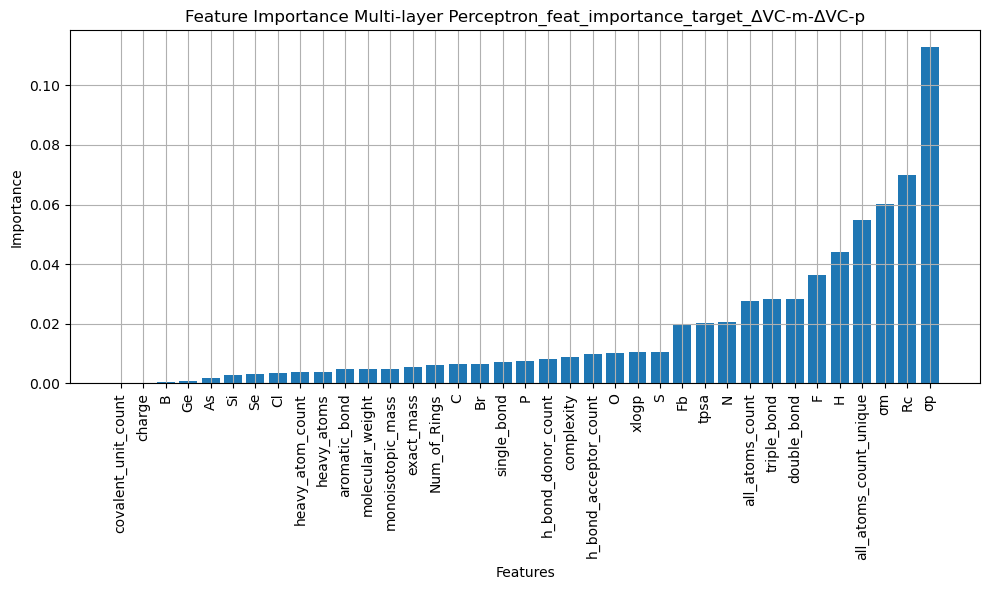

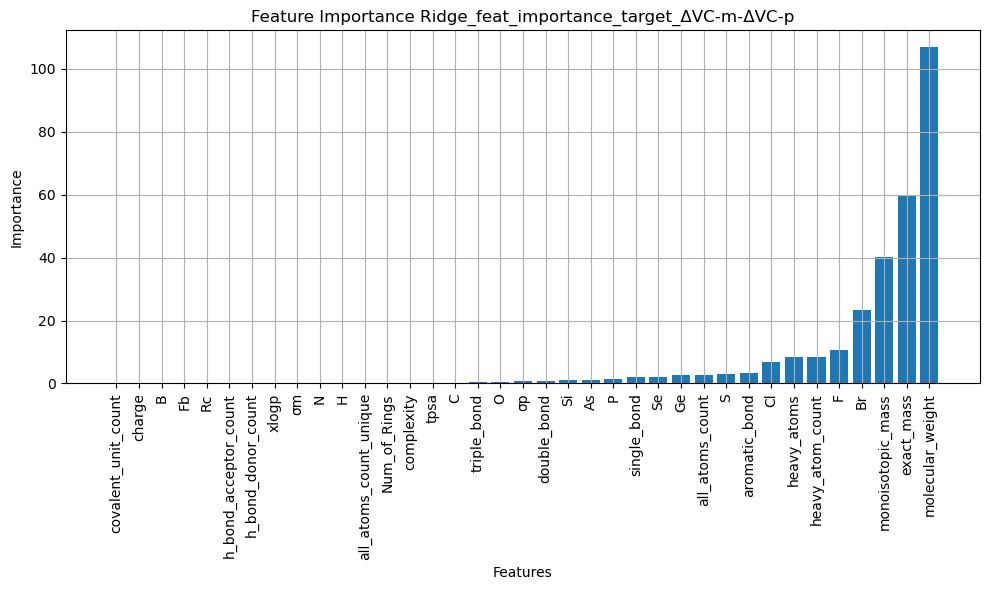

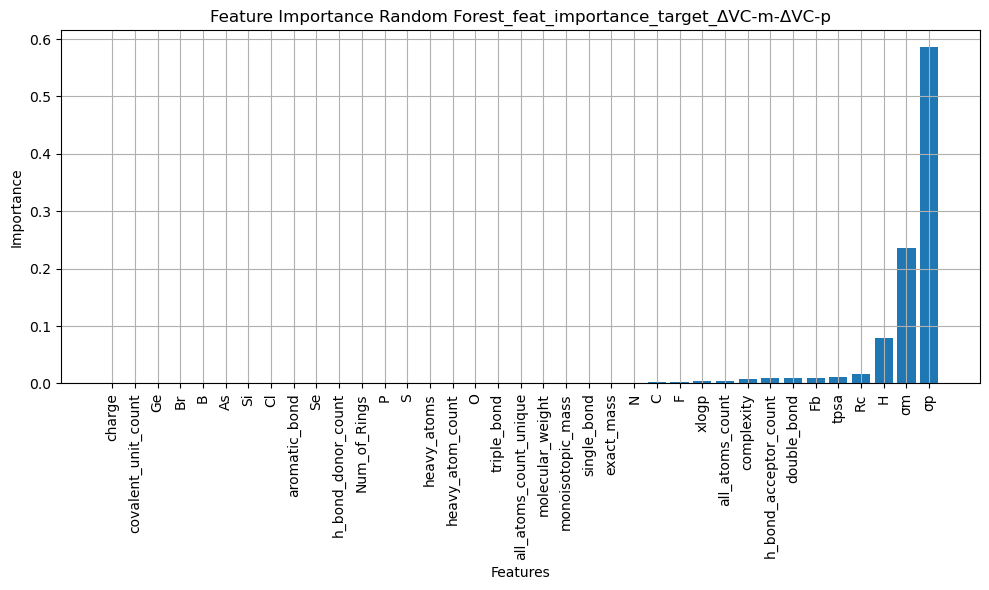

In [16]:
feature_importance_per_model = {}
for name, model_best in best_models_dictionary.items() : 
    print(name)
    feat_name, feat_importance = plot_features_using_permutation_importance( model=model_best,X_train=X_train, y_train=y_train, random_state=rng, feature_names_ori=feature_names_involved_in_training,filename=f"{path_to_parent_folder}/figures/{name}_feat_importance_target_{target_feature_name}")
    feature_importance_per_model[name] = ( feat_name , feat_importance ) 

In [17]:
best_models_dictionary

{'Multi-layer Perceptron': MLPRegressor(alpha=1.5037553212997384e-06, batch_size=64,
              hidden_layer_sizes=(1200, 1200), learning_rate='invscaling'),
 'Ridge': Ridge(alpha=3.4240061379714256e-05),
 'Random Forest': RandomForestRegressor(criterion='friedman_mse', max_depth=10,
                       max_features='auto', min_samples_split=10,
                       n_estimators=1000)}